In [1]:
#UDACITY UD730 - assignement 1 notMNIST
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


In [7]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [8]:
print (os.path.abspath(''))

C:\Users\Vince\Documents\GitHub\UD730


In [10]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
#train_folders = maybe_extract(train_filename)
#test_folders = maybe_extract(test_filename)
train_folders = maybe_extract('./notMNIST_large')
test_folders = maybe_extract('./notMNIST_small')

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.
['./notMNIST_large\\A', './notMNIST_large\\B', './notMNIST_large\\C', './notMNIST_large\\D', './notMNIST_large\\E', './notMNIST_large\\F', './notMNIST_large\\G', './notMNIST_large\\H', './notMNIST_large\\I', './notMNIST_large\\J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.
['./notMNIST_small\\A', './notMNIST_small\\B', './notMNIST_small\\C', './notMNIST_small\\D', './notMNIST_small\\E', './notMNIST_small\\F', './notMNIST_small\\G', './notMNIST_small\\H', './notMNIST_small\\I', './notMNIST_small\\J']


In [11]:
#Problem 1 : Let's take a peek at some of the data to make sure it looks sensible.
#Each exemplar should be an image of a character A through J rendered in a different font. 
#Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

listOfImageNames = ['notMNIST_large/I/R2VvbWV0cmljIFNsYWJzZXJpZiA3MDMgQm9sZCBJdGFsaWMucGZi.png',
                    'notMNIST_large/J/aG9uZXkgVWx0cmEudHRm.png',
                    'notMNIST_large/A/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/B/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/C/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/D/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/E/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/F/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/G/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/H/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/I/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/J/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/C/a2ltaWRvcmkgbXVnY3VwLnR0Zg==.png']

listOfSmallImageNames = ['notMNIST_small/J/Q2FzdWFsLnR0Zg==.png',
                    'notMNIST_small/A/MTggSG9sZXMgQlJLLnR0Zg==.png',
                    'notMNIST_small/A/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/B/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/C/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/D/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/E/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/F/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/G/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/H/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/I/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/J/Q0sgUGluay50dGY=.png']

#print (os.path.abspath(''))
print ("large images")
for imageName in listOfImageNames:
    display(Image(filename=imageName))
print ("small images")
for smallImageName in listOfSmallImageNames:
    display(Image(filename=smallImageName))

large images


small images


In [20]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  #print ('image_files ', image_files)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print ('dataset.size ', dataset.size, 'dataset.shape ', dataset.shape)
  print(folder)
  num_images = 0
  selectedImagesToShow = np.random.randint(0, dataset.shape[0])
  print ('expected image number %d of %d samples' % (selectedImagesToShow, dataset.shape[0]))
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      #ndimage.imread = Read an image from a file as an array
      #Returns: img_array (ndarray). The different colour bands/channels are stored in the third dimension, 
      #such that a grey-image is MxN, an RGB-image MxNx3 and an RGBA-image MxNx4.
      #plus data normalization
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if num_images == selectedImagesToShow:
          print ('images #', num_images, ', file', image_file)
          display(Image(filename=image_file))
          print ('image_data ', image_data) 
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  #3D Matrix : normalized value of the W&B pixel per num_image x row (28) x col (28)
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
  print ('dataset [0:2,:,:] ',dataset [0:2,:,:])  
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large\A.pickle already present - Skipping pickling.
./notMNIST_large\B.pickle already present - Skipping pickling.
./notMNIST_large\C.pickle already present - Skipping pickling.
Pickling ./notMNIST_large\D.pickle.
dataset.size  41483008 dataset.shape  (52912L, 28L, 28L)
./notMNIST_large\D
expected image number 13126 of 52912 samples
images # 13126 , file ./notMNIST_large\D\QXVyb3JhQlQtQm9sZENvbmRlbnNlZC5vdGY=.png


image_data  [[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.49215686  0.45686275  0.42941176  0.3745098   0.26470588
   0.15882353 -0.0372549  -0.28431373 -0.47254902 -0.5        -0.49215686
  -0.49215686 -0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.49215686  0.31568627 -0.1        -0.46470588 -0.5
  -0.49607843]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.49607843  0.49607843  0.49215686
   0.48823529  0.49215686  0.49607843  0.49607843  0.5         0.25686275
  -0.38627451 -0.5       ]
 [ 

image_data  [[-0.24901961  0.29215686  0.4372549   0.47647059  0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.48823529  0.44901961  0.32745098
  -0.18627451]
 [ 0.33529412  0.5         0.49607843  0.5         0.5         0.5
   0.49607843  0.49607843  0.49607843  0.49607843  0.49607843  0.49607843
   0.49607843  0.49607843  0.49607843  0.49607843  0.49607843  0.49607843
   0.49607843  0.49607843  0.49607843  0.49607843  0.5         0.5         0.5
   0.49607843  0.5         0.35490196]
 [ 0.49607843  0.49215686  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.49215686
   0.49607843]
 [ 

image_data  [[ 0.39803922  0.5         0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.39019608  0.5         0.48431373  0.49215686  0.5         0.5         0.5
   0.5         0.5         0.5         0.49607843  0.48823529  0.48823529
   0.48823529  0.48823529  0.48823529  0.48823529  0.48823529  0.48823529
   0.48823529  0.48823529  0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5       ]
 [ 0.42156863  0.5         0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.18

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.5        -0.39019608 -0.15490196 -0.14313725 -0.20196078
  -0.20980392 -0.17058824 -0.1        -0.14705882 -0.40980392 -0.5
  -0.49215686 -0.49607843 -0.48431373 -0.5        -0.5        -0.5
  -0.42156863 -0.36666667 -0.40980392 -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.49215686
  -0.5        -0.29607843 -0.13137255 -0.37058824 -0.5        -0.5        -0.5
  -0.5        -0.48431373 -0.31176471 -0.06470588 -0.24117647 -0.5        -0.5
  -0.5        -0.41372549 -0.12352941 -0.03333333 -0.12745098 -0.2254902
  -0.20980392 -0.24901961]
 [-0.5        -0.5        -0.5        -0.5        -0.49607843 -0.5
  -0.33529412 -0.15098039 -0.5        -0.5        -0.49607843 -0.49215686
  -0.49215686 -0.49215686 -0.5        -0.5        -0.48823529 -0.10392157
  -0.26470588 -0.41764706  0.07647059  0.19411765 -0.11176471 -0.41764706
  -0.5        -0.5        -0.5        -0.

image_data  [[ 0.24509804  0.48431373  0.48431373  0.5         0.5         0.5         0.5
   0.5         0.5         0.48039216  0.48039216  0.19803922 -0.5
  -0.49215686 -0.48039216 -0.5         0.03333333  0.48039216  0.47647059
   0.5         0.5         0.5         0.5         0.5         0.5
   0.48823529  0.48431373  0.27647059]
 [ 0.29215686  0.5         0.5         0.49607843  0.5         0.5         0.5
   0.5         0.49607843  0.5         0.5         0.24117647 -0.5
  -0.49215686 -0.48039216 -0.5         0.06862745  0.5         0.5
   0.49607843  0.5         0.5         0.5         0.5         0.49607843
   0.5         0.5         0.33529412]
 [-0.20980392  0.00196078  0.39019608  0.5         0.49607843  0.5         0.5
   0.49607843  0.5         0.30784314 -0.01372549 -0.2254902  -0.5
  -0.49607843 -0.49215686 -0.5        -0.28823529  0.03333333  0.31960784
   0.5         0.49607843  0.5         0.5         0.49607843  0.5
   0.43333333  0.07254902 -0.16666667]
 [-0.5    

image_data  [[-0.5        -0.5        -0.5        -0.39411765 -0.2372549  -0.09607843
   0.04901961  0.1745098   0.28823529  0.33921569  0.38235294  0.41764706
   0.44509804  0.47254902  0.47254902  0.44117647  0.41372549  0.37843137
   0.33137255  0.27254902  0.15490196  0.02941176 -0.11176471 -0.24509804
  -0.40196078 -0.5        -0.5        -0.5       ]
 [-0.31176471 -0.14705882  0.1745098   0.34705882  0.48039216  0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.48039216  0.33529412  0.15882353 -0.15882353
  -0.31960784]
 [ 0.37058824  0.40980392  0.48039216  0.49607843  0.48823529  0.48823529
   0.48823529  0.49215686  0.49215686  0.49607843  0.49607843  0.49607843
   0.49607843  0.5         0.5         0.49607843  0.49607843  0.49607843
   0.49607843  0.49215686  0.49215686  0.48823529  0.48823529  0.48823529
   0.49607843  0.48

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.49607843
  -0.5        -0.46078431 -0.27647059 -0.10392157  0.08823529  0.26470588
   0.4254902   0.5         0.5         0.5         0.48431373  0.5
   0.17843137 -0.5        -0.49607843]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.49215686
  -0.5         0.04509804  0.5         0.48823529  0.5         0.5         0.5
   0.5         0.5         0.5         0.49607843  0.5         0.46470588
  -0.3627451  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.48823529
  -0.5         0.02156863  0.5         0.47254902  0.48823529  0.49215686
   0.5         0.5         0.5         0.5         0.5         0.49215686
   0.5        -0.0254

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.5        -0.33137255  0.45294118  0.5         0.49215686
   0.5         0.39411765 -0.41764706 -0.5        -0.49607843 -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.5         0.14705882  0.5         0.48823529  0.5
   0.49607843  0.5        -0.27254902 -0.5        -0.49215686 -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.48823529
  -0.5        -0.21764706  0.5         0.49607843  0.49607843  0.5
   0.48823529  0.5        -0.00588235 -0.5        -0.48823529 -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.

image_data  [[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.48431373  0.48431373  0.49607843  0.5         0.5         0.5         0.5
   0.5         0.49215686  0.44509804  0.39411765  0.29607843  0.10784314
  -0.1745098  -0.46470588 -0.5        -0.49215686 -0.49215686 -0.5        -0.5
  -0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.49215686
   0.49215686  0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.35490196 -0.10784314 -0.49607843 -0.49607843 -0.49607843
  -0.5        -0.5       ]
 [ 0.5         0.5         0.5         0.5         0.49215686  0.5
   0.48823529  0.21372549 -0.10392157 -0.25686275 -0.30784314 -0.31176471
  -0.31176471 -0.31176471 -0.3        -0.22156863 -0.01372549  0.34313725
   0.5         0.48039216  0.49215686  0.49607843  0.5         0.18627451
  -0.46470588 -0.5        -0.49607843 -0

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.49607843
  -0.49607843 -0.5        -0.5        -0.48431373 -0.33529412 -0.24509804
  -0.14313725 -0.10392157 -0.0254902   0.0254902   0.1         0.15882353
   0.15098039  0.02941176 -0.13137255 -0.06470588 -0.02156863  0.00196078
   0.16666667  0.15490196 -0.41372549 -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.49607843 -0.49607843
  -0.5        -0.48039216 -0.13921569  0.00588235 -0.13529412 -0.29215686
  -0.37843137 -0.42156863 -0.3745098  -0.31176471 -0.20588235  0.02941176
   0.32352941  0.49607843  0.15098039 -0.36666667 -0.5        -0.39803922
   0.34705882  0.5        -0.35098039 -0.5       ]
 [-0.5        -0.5        -0.5        -0.49607843 -0.5        -0.44901961
  -0.26470588  0.26470588  0.04901961 -0.43333333 -0.5        -0.49607843
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.49607843
  -0.5        -0.28823529  0.22156863  0.40588235 -0.14705882 -0.5
   0.

image_data  [[ 0.24901961  0.5         0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.44509804  0.3745098   0.28823529  0.08823529 -0.19411765
  -0.42941176 -0.5        -0.5        -0.48823529 -0.5        -0.5        -0.5
  -0.5       ]
 [ 0.24901961  0.5         0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.37058824 -0.02941176 -0.43333333 -0.5        -0.48823529 -0.5        -0.5
  -0.5       ]
 [ 0.24901961  0.5         0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.49607843  0.49215686  0.48823529  0.49607843
   0.5         0.5         0.34705882 -0.28823529 -0.5        -0.48823529
  -0.5        -0.5       ]
 [ 0.24117

image_data  [[-0.5        -0.49607843 -0.48431373 -0.40196078  0.44901961  0.5
   0.49607843  0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.49607843  0.5         0.40980392 -0.42941176 -0.48431373
  -0.49607843 -0.5       ]
 [-0.5        -0.5        -0.5        -0.48039216  0.44509804  0.5
   0.49607843  0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.49607843  0.5         0.40196078 -0.5        -0.5        -0.5
  -0.5       ]
 [-0.49607843 -0.45294118  0.00588235  0.07647059  0.47254902  0.5
   0.49607843  0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.49607843  0.5         0.45686275  0.06862745 -0.01372549
  -0.46862745 -0.49607843]
 [-0.5        -0.

image_data  [[-0.11568627  0.5         0.5         0.49607843  0.48431373  0.48823529
   0.5         0.41372549  0.00980392 -0.39019608 -0.5        -0.49607843
  -0.49215686 -0.48431373 -0.48823529 -0.18235294  0.26078431  0.48431373
   0.5         0.46078431  0.45686275  0.47647059  0.5         0.30392157
  -0.14313725 -0.46862745 -0.5        -0.49607843]
 [-0.5        -0.32352941  0.08039216  0.42156863  0.5         0.5
   0.48823529  0.49215686  0.5         0.42156863  0.08431373 -0.32352941
  -0.5        -0.5        -0.49607843 -0.5        -0.44901961 -0.15098039
   0.26470588  0.49215686  0.5         0.49607843  0.48823529  0.5         0.5
   0.33529412 -0.06862745 -0.40588235]
 [-0.5        -0.49607843 -0.5        -0.40588235 -0.04509804  0.35098039
   0.5         0.5         0.49215686  0.49607843  0.5         0.48039216
   0.20196078 -0.2254902  -0.48039216 -0.5        -0.49607843 -0.5
  -0.49607843 -0.27254902  0.14705882  0.45686275  0.5         0.49607843
   0.48823529  0.49

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.48823529 -0.49607843 -0.5        -0.49607843 -0.35098039
  -0.06470588  0.13137255  0.20980392  0.21372549  0.1627451   0.01764706
  -0.26470588 -0.49215686 -0.5        -0.48823529 -0.5        -0.3745098
  -0.39019608 -0.5        -0.49607843]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.49215686 -0.5        -0.45294118 -0.12352941  0.28039216
   0.5         0.28823529  0.00588235 -0.15098039 -0.16666667 -0.08039216
   0.11960784  0.40588235  0.33529412 -0.1745098  -0.5        -0.26862745
   0.46078431 -0.1        -0.5        -0.48823529]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.48823529
  -0.49607843 -0.49607843 -0.13137255  0.37058824  0.5         0.4254902
  -0.19411765 -0.5        -0.49607843 -0.5        -0.5        -0.49607843
  -0.5        -0.43333333  0.18235294  0.5         0.19019608  0.41372549
   0.5        

image_data  [[-0.5        -0.49215686 -0.5        -0.25294118  0.31176471  0.37843137
   0.5         0.5         0.49607843  0.5         0.46078431  0.32352941
  -0.09215686 -0.5        -0.48823529 -0.5        -0.5        -0.5
  -0.48431373  0.1745098   0.32745098  0.48039216  0.5         0.49607843
   0.5         0.5         0.3627451   0.25294118]
 [-0.5        -0.5        -0.5        -0.49607843 -0.5        -0.4254902
   0.29215686  0.5         0.49607843  0.42156863 -0.27647059 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.49215686 -0.48823529 -0.05294118  0.5         0.48039216
   0.5         0.00980392 -0.44901961 -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.48431373 -0.5
   0.08823529  0.5         0.5         0.08823529 -0.5        -0.48823529
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.48823529 -0.5        -0.31568627  0.5         0.5         0.41764706
  -0.45686275 -

image_data  [[-0.43333333  0.15882353  0.47647059  0.49215686  0.49607843  0.49607843
   0.49607843  0.49607843  0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49607843  0.49607843  0.49607843  0.49607843  0.49607843  0.49215686
   0.47254902  0.14313725 -0.4372549 ]
 [-0.22156863  0.5         0.48431373  0.5         0.5         0.5         0.5
   0.5         0.5         0.49607843  0.49215686  0.5         0.5         0.5
   0.5         0.5         0.5         0.49215686  0.49607843  0.5         0.5
   0.5         0.5         0.5         0.5         0.48431373  0.5
  -0.22156863]
 [-0.40980392  0.21764706  0.49215686  0.48431373  0.48823529  0.48823529
   0.48823529  0.48823529  0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.48823529  0.48823529  0.48823529  0.48823529  0.48431373
   0.48823529  0.20980392 -0.41372549]
 [-

image_data  [[-0.49215686 -0.5        -0.40196078  0.21372549  0.48039216  0.47254902
   0.5         0.5         0.5         0.5         0.49215686  0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.49607843  0.5         0.5         0.5         0.49607843
   0.47647059  0.06862745]
 [-0.5        -0.5        -0.49215686 -0.42156863 -0.37843137 -0.35882353
  -0.30392157 -0.21372549 -0.05686275  0.26470588  0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49607843  0.5         0.43333333  0.06470588 -0.17843137 -0.27647059
  -0.33529412 -0.3745098  -0.4372549 ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.48039216  0.16666667  0.5         0.49215686
   0.5         0.5         0.5         0.5         0.5         0.49607843
   0.5         0.45294118 -0.15098039 -0.5        -0.48431373 -0.5        -0.5
  -0.5        -0

train_datasets  ['./notMNIST_large\\A.pickle', './notMNIST_large\\B.pickle', './notMNIST_large\\C.pickle', './notMNIST_large\\D.pickle', './notMNIST_large\\E.pickle', './notMNIST_large\\F.pickle', './notMNIST_large\\G.pickle', './notMNIST_large\\H.pickle', './notMNIST_large\\I.pickle', './notMNIST_large\\J.pickle']
dataset_name  ./notMNIST_large\A.pickle dataset.shape[0]  52909 indices  [25059 47471 45061  8712  6626]


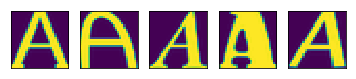

dataset_name  ./notMNIST_large\B.pickle dataset.shape[0]  52911 indices  [49774 28114 28210   956 28316]


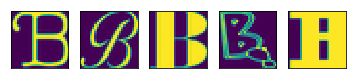

dataset_name  ./notMNIST_large\C.pickle dataset.shape[0]  52881 indices  [11746  5528 24718 32855 19650]


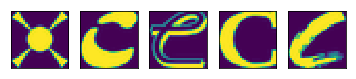

dataset_name  ./notMNIST_large\D.pickle dataset.shape[0]  52911 indices  [32773  9954 29898 48983 49735]


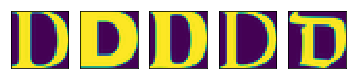

dataset_name  ./notMNIST_large\E.pickle dataset.shape[0]  52912 indices  [10218 27519 10316  7223 31008]


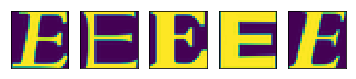

dataset_name  ./notMNIST_large\F.pickle dataset.shape[0]  52912 indices  [ 9554 35998  9023  8489 33636]


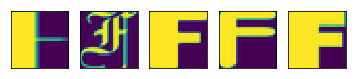

dataset_name  ./notMNIST_large\G.pickle dataset.shape[0]  52912 indices  [  169 23859 14545 27715 15018]


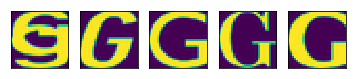

dataset_name  ./notMNIST_large\H.pickle dataset.shape[0]  52912 indices  [28764 38777 15786 15066 19487]


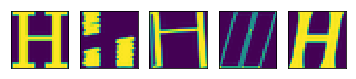

dataset_name  ./notMNIST_large\I.pickle dataset.shape[0]  52912 indices  [51342 23419 23919 33585 27876]


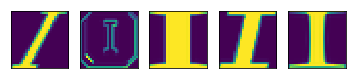

dataset_name  ./notMNIST_large\J.pickle dataset.shape[0]  52911 indices  [10950 13651 26426 41543 43404]


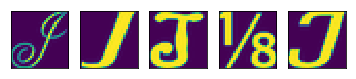

test_datasets  ['./notMNIST_small\\A.pickle', './notMNIST_small\\B.pickle', './notMNIST_small\\C.pickle', './notMNIST_small\\D.pickle', './notMNIST_small\\E.pickle', './notMNIST_small\\F.pickle', './notMNIST_small\\G.pickle', './notMNIST_small\\H.pickle', './notMNIST_small\\I.pickle', './notMNIST_small\\J.pickle']
dataset_name  ./notMNIST_small\A.pickle dataset.shape[0]  1872 indices  [1720 1692   47 1760  360]


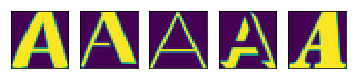

dataset_name  ./notMNIST_small\B.pickle dataset.shape[0]  1873 indices  [ 945 1225  598 1557  698]


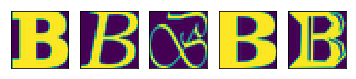

dataset_name  ./notMNIST_small\C.pickle dataset.shape[0]  1873 indices  [1442 1447  251 1346  533]


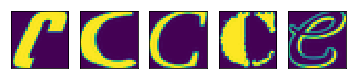

dataset_name  ./notMNIST_small\D.pickle dataset.shape[0]  1873 indices  [1494 1382 1233  287  964]


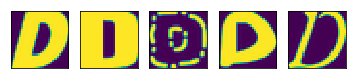

dataset_name  ./notMNIST_small\E.pickle dataset.shape[0]  1873 indices  [1356 1649 1162  173 1530]


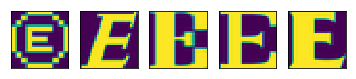

dataset_name  ./notMNIST_small\F.pickle dataset.shape[0]  1872 indices  [  80 1304 1059 1109 1576]


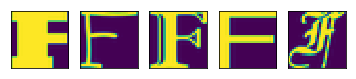

dataset_name  ./notMNIST_small\G.pickle dataset.shape[0]  1872 indices  [1124  414 1794  898  180]


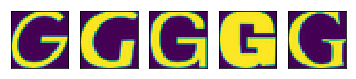

dataset_name  ./notMNIST_small\H.pickle dataset.shape[0]  1872 indices  [1650  710  184  995  671]


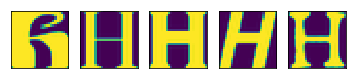

dataset_name  ./notMNIST_small\I.pickle dataset.shape[0]  1872 indices  [ 262 1198  937  574 1846]


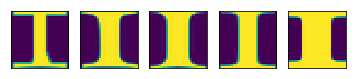

dataset_name  ./notMNIST_small\J.pickle dataset.shape[0]  1872 indices  [1616 1174  846 1384 1818]


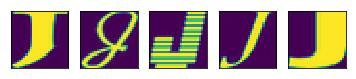

In [21]:
#Problem 2 : Let's verify that the data still looks good. 
#Displaying a sample of the labels and images from the ndarray. 
#Hint: you can use matplotlib.pyplot.

%matplotlib inline
def showProcessedRandom(dataset_name,n): # shows size of the sample
    with open(dataset_name, 'rb') as f:
        dataset = pickle.load(f)
        indices=np.random.choice(dataset.shape[0], n)
        print ('dataset_name ', dataset_name, 'dataset.shape[0] ',dataset.shape[0], 'indices ', indices)
        fig=plt.figure()
        for i in range(n):
            a=fig.add_subplot(1,n,i+1)
            plt.imshow(dataset[indices[i],:,:])
            # a.set_title(chr(labels[indices[i]]+ord('A')))
            a.axes.get_xaxis().set_visible(False)
            a.axes.get_yaxis().set_visible(False)
        plt.show()
    f.close()

print ('train_datasets ',train_datasets)
for name in train_datasets:
    showProcessedRandom(name,5) 

print ('test_datasets ',test_datasets)
for name in test_datasets:
    showProcessedRandom(name,5)

Number of images in  ./notMNIST_large\A.pickle  :  52909


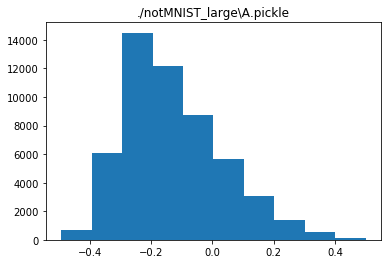

Number of images in  ./notMNIST_large\B.pickle  :  52911


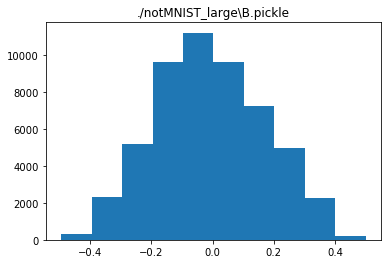

Number of images in  ./notMNIST_large\C.pickle  :  52881


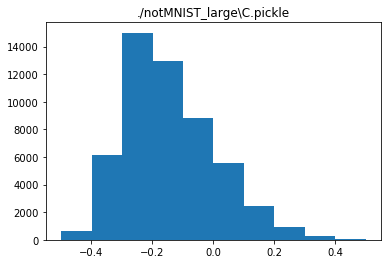

Number of images in  ./notMNIST_large\D.pickle  :  52911


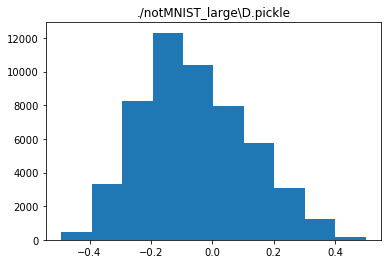

Number of images in  ./notMNIST_large\E.pickle  :  52912


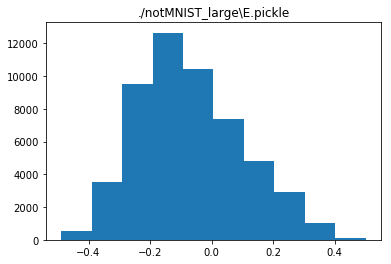

Number of images in  ./notMNIST_large\F.pickle  :  52912


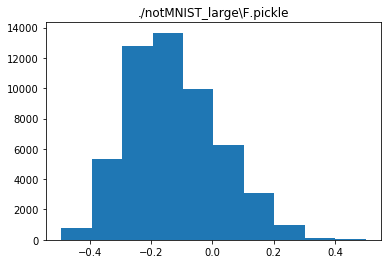

Number of images in  ./notMNIST_large\G.pickle  :  52912


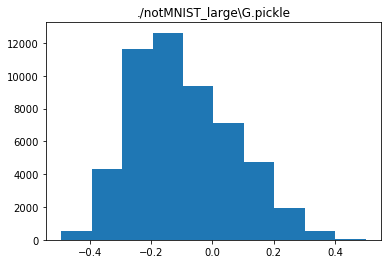

Number of images in  ./notMNIST_large\H.pickle  :  52912


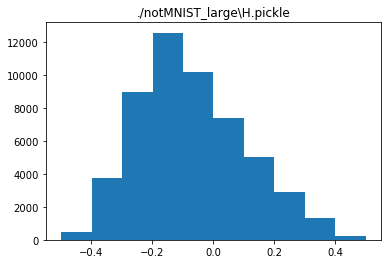

Number of images in  ./notMNIST_large\I.pickle  :  52912


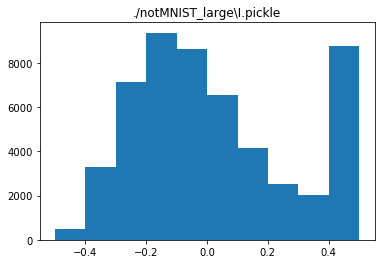

Number of images in  ./notMNIST_large\J.pickle  :  52911


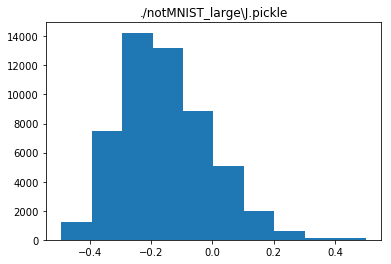

Number of images in  ./notMNIST_small\A.pickle  :  1872


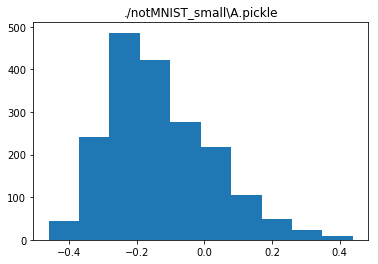

Number of images in  ./notMNIST_small\B.pickle  :  1873


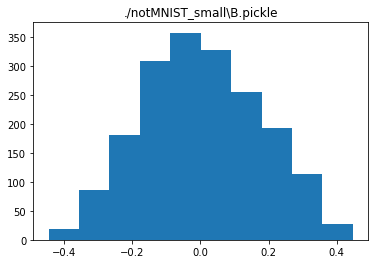

Number of images in  ./notMNIST_small\C.pickle  :  1873


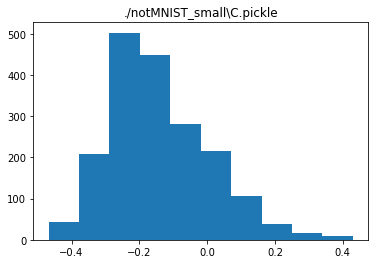

Number of images in  ./notMNIST_small\D.pickle  :  1873


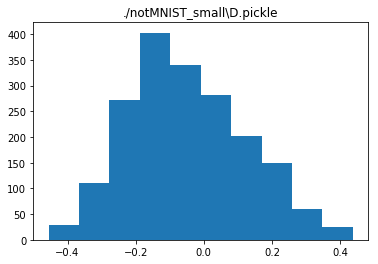

Number of images in  ./notMNIST_small\E.pickle  :  1873


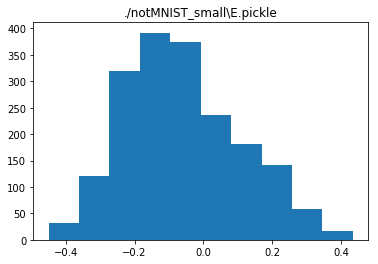

Number of images in  ./notMNIST_small\F.pickle  :  1872


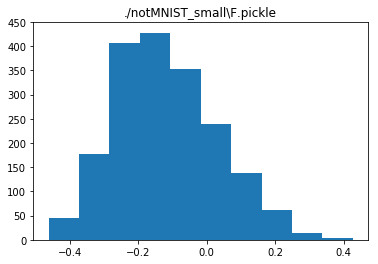

Number of images in  ./notMNIST_small\G.pickle  :  1872


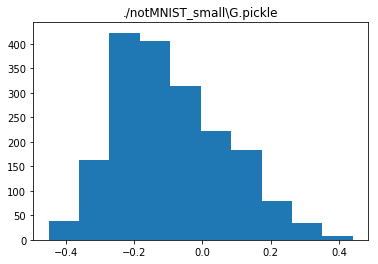

Number of images in  ./notMNIST_small\H.pickle  :  1872


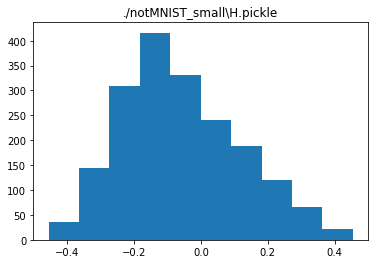

Number of images in  ./notMNIST_small\I.pickle  :  1872


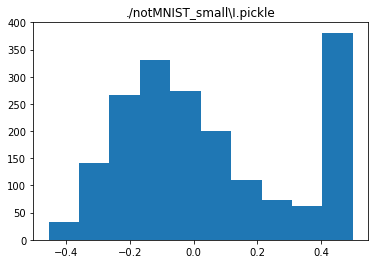

Number of images in  ./notMNIST_small\J.pickle  :  1872


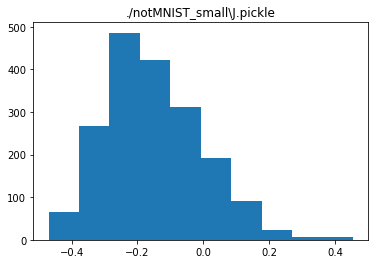

In [24]:
#Problem 3
#Another check: we expect the data to be balanced across classes. Verify that.

def showDistribution(dataset_name):
    data = []
    try:
        with open(dataset_name, 'rb') as f:
            data = pickle.load(f)
    except Exception as e:
        print('Unable to load data to', dataset_name, ':', e)
    print('Number of images in ', dataset_name, ' : ', len(data))

    fig, ax = plt.subplots()
    ax.set_title(dataset_name)
    ax.hist([np.mean(arr) for arr in data])
    plt.show()

for name in train_datasets:
    showDistribution(name)
for name in test_datasets:
    showDistribution(name)


In [25]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000L, 28L, 28L) (200000L,)
Validation: (10000L, 28L, 28L) (10000L,)
Testing: (10000L, 28L, 28L) (10000L,)


In [38]:
#numpy.random.choice(a, size=None, replace=True, p=None) : Generates a random sample from a given 1-D array

#numpy.random.shuffle(x) : Modify a sequence in-place by shuffling its contents. => modify object itself
#This function only shuffles the array along the first axis of a multi-dimensional array. 
#The order of sub-arrays is changed but their contents remains the same.

#numpy.random.permutation(x) : Randomly permute a sequence, or return a permuted range => return a copy
#If x is a multi-dimensional array, it is only shuffled along its first index.

#np.random.randint(a, b)
#Return a random integer N such that a <= N <= b. Alias for randrange(a, b+1).


In [26]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

train set dataset.shape[0]  200000 indices  [187606  24311  66883  57708 175400  83314]


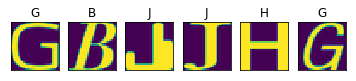

test set dataset.shape[0]  10000 indices  [6686 1190 6806 1282 1802  404]


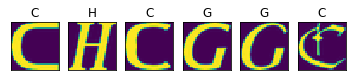

validation set dataset.shape[0]  10000 indices  [ 744 9588 6618 9069 1738 7995]


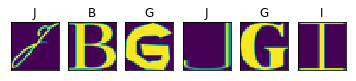

In [27]:
#Problem 4 : Convince yourself that the data is still good after shuffling!

fLabels = {0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E', 5 : 'F', 6 : 'G', 7 : 'H', 8 : 'I', 9 : 'J'}

def showProcessedShuffled(name,dataset,label,n): # shows size of the sample
    fig = plt.figure()
    indices=np.random.choice(dataset.shape[0], n)
    print (name, 'dataset.shape[0] ',dataset.shape[0], 'indices ', indices)
    for i in range(n):
            a=fig.add_subplot(1,n,i+1)
            plt.imshow(dataset[indices[i],:,:])
            tlabel = fLabels[label[indices[i]]]
            plt.title(tlabel)
            #a.set_title(chr(labels[indices[i]]+ord('A')))
            a.axes.get_xaxis().set_visible(False)
            a.axes.get_yaxis().set_visible(False)
    plt.show()

showProcessedShuffled('train set', train_dataset,train_labels,6)
showProcessedShuffled('test set', test_dataset,test_labels,6)
showProcessedShuffled('validation set', valid_dataset,valid_labels,6) 


In [28]:
#Finally, let's save the data for later reuse:

data_root = '.' 
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [29]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800451


In [30]:
#Problem 5
"""By construction, this dataset might contain a lot of overlapping samples, including training data 
that's also contained in the validation and test set! Overlap between training and test can skew the results 
if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect 
to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.
Optional questions:
What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
"""
import time
import hashlib

t1 = time.time()

train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

#np.in1d : Test whether each element of a 1-D array is also present in a second array.
#Returns a boolean array the same length as ar1 that is True where an element of ar1 is in ar2 and False otherwise.
valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

#magic boolean operations
#a = np.array([True, True, False, False])
#b = np.array([True, False, True, False])
#c = (a | b) :[ True  True  True False]
# ~c :        [False False False  True]
valid_keep = ~valid_in_train
test_keep  = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))
print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())



Time: 1.86s
valid -> train overlap: 1049 samples
test  -> train overlap: 1316 samples
test  -> valid overlap: 200 samples


prediction test 50 samples, score 0.6035 dataset.shape[0]  8638 indices  [6243 6231 7555 7957 4608  116]


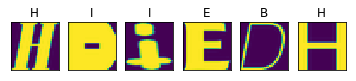

prediction test 100 samples, score 0.7560 dataset.shape[0]  8638 indices  [5834 4305 4139 3228 6573 4121]


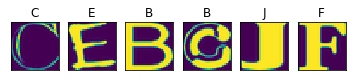

prediction test 1000 samples, score 0.8357 dataset.shape[0]  8638 indices  [8345 6351 2834 2453 6221 5141]


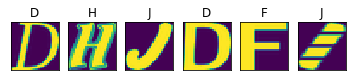

prediction test 5000 samples, score 0.8402 dataset.shape[0]  8638 indices  [7958   27 7307 6000 5680 5773]


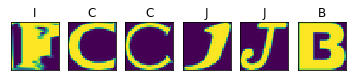

prediction test 10000 samples, score 0.8517 dataset.shape[0]  8638 indices  [6229  567 6736 7254 6592 1305]


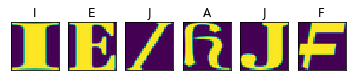

prediction test 50000 samples, score 0.8782 dataset.shape[0]  8638 indices  [ 401 8610 6787 4569 6501 7464]


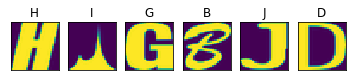

prediction validation set, score 0.8782 dataset.shape[0]  8951 indices  [5370 8011 2909 1893 8931 2041]


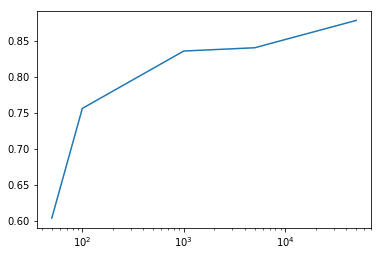

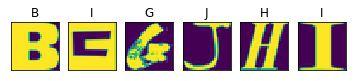

prediction test all data set, score 0.8782 dataset.shape[0]  8638 indices  [6248 7231 8545 7889 1680 8215]


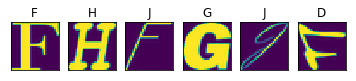

prediction validation all data set, score 0.8782 dataset.shape[0]  8951 indices  [5676 6223 6919 2094 6527 4794]


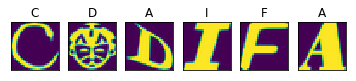

In [37]:
#Problem 6
"""Let's get an idea of what an off-the-shelf classifier can give you on this data. 
It's always good to check that there is something to learn, and that it's a problem that is not so trivial 
that a canned solution solves it.
Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 
Hint: you can use the LogisticRegression model from sklearn.linear_model.
Optional question: train an off-the-shelf model on all the data!
"""

logReg = LogisticRegression()
res = {}
X_test = test_dataset_clean.reshape(len(test_dataset_clean), 28 * 28)
X_valid = valid_dataset_clean.reshape(len(valid_dataset_clean), 28 * 28)

for size in [50, 100, 1000, 5000, 10000, 50000]:
    logReg.fit(train_dataset[:size].reshape(size, 28 * 28), train_labels[:size])
    score = logReg.score(X_test, test_labels_clean)
    pred_test = logReg.predict(X_test)
    showProcessedShuffled('prediction test %d samples, score %0.4f' % (size,score), test_dataset_clean, pred_test, 6)
    res[size] = {'logReg': logReg, 'score': score}

keys = res.keys()
keys.sort()
plt.xscale('log')
plt.plot(keys, [res[k]['score'] for k in keys])

validationScore = logReg.score(X_valid, valid_labels_clean)
pred_valid = logReg.predict(X_valid)
showProcessedShuffled('prediction validation set, score %0.4f' % score, valid_dataset_clean, pred_valid, 6)

#training on all the dataset
logReg2 = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
logReg2.fit(train_dataset[:sample_size].reshape(sample_size, 28 * 28), train_labels[:sample_size])
logReg2.score(X_test, test_labels_clean)
pred_test2 = logReg2.predict(X_test)
showProcessedShuffled('prediction test all data set, score %0.4f' % score, test_dataset_clean, pred_test, 6)

validationScore = logReg2.score(X_valid, valid_labels_clean)
pred_valid = logReg2.predict(X_valid)
showProcessedShuffled('prediction validation all data set, score %0.4f' % score, valid_dataset_clean, pred_valid, 6)

